In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [3]:
image = cv2.imread('/home/arvind/LLM_Tool/Save_dir/Pick up the flate-plate pressing tool._0914_203148/step0/Image1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

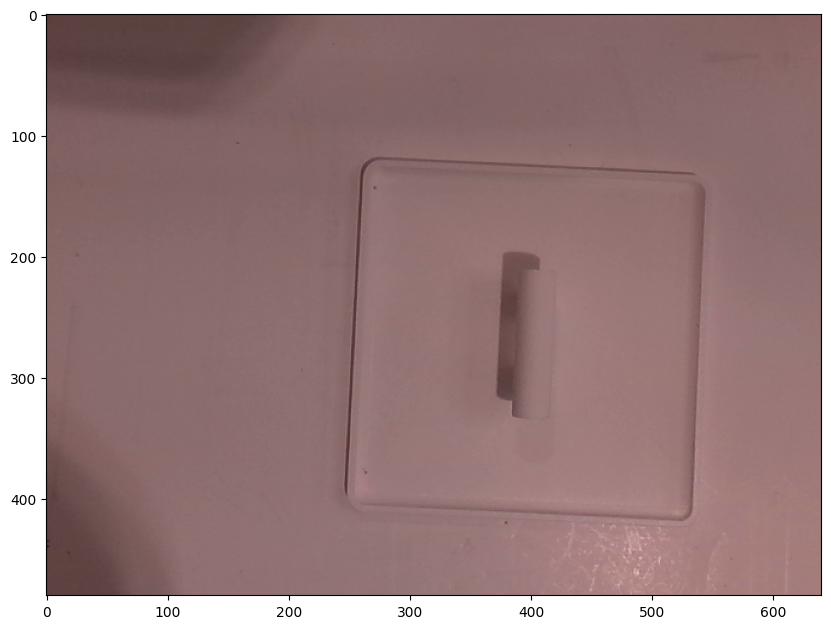

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:
masks = mask_generator.generate(image)

In [7]:
print(len(masks))
print(masks[0].keys())

7
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    m = sorted_anns[1]['segmentation']
    color_mask = [0, 0, 0]
    img[m] = np.concatenate([color_mask, [1]])

    """
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        print(color_mask)
        img[m] = color_mask
    """
    ax.imshow(img)

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.zeros((sorted_anns[1]['segmentation'].shape[0], sorted_anns[1]['segmentation'].shape[1], 4))  # Initialize with zeros for full transparency
    m = sorted_anns[1]['segmentation']
    color_mask = [0, 0, 0]
    img[m] = np.concatenate([color_mask, [1]])  # Set alpha to 1 for full opacity of the mask

    ax.imshow(img)
    plt.show()

In [10]:
# plt.figure(figsize=(20,20))
# plt.imshow(image)
# mask = masks[0]['segmentation'].shape



# # Scale the mask to 255 for better visualization

# # Plot the original image using matplotlib
# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# plt.title("Original Image")
# plt.show()

# Plot the mask using OpenCV

from ipywidgets import interact

image = cv2.resize(image, (394,396))
# mask = cv2.resize(mask, (394,396))

def display_mask(index):
    mask = masks[index]['segmentation'].astype(np.uint8)
    mask *= 255
    mask = cv2.resize(mask, (394, 396))

    # Convert single channel mask to 3-channel to overlay on image
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # Overlay the mask on the image
    overlay = cv2.addWeighted(image, 0.7, mask_rgb, 0.3, 0)

    # Display the image with the mask overlay
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.title(f"Mask {index + 1}")
    plt.axis("off")
    plt.show()

# Interactive widget to select the mask by index
interact(display_mask, index=(0, len(masks) - 1))




interactive(children=(IntSlider(value=3, description='index', max=6), Output()), _dom_classes=('widget-interac…

<function __main__.display_mask(index)>

In [11]:
# Change these values based on what you observe to be the best masks in the prev cell
bestobj_idx = 1
bestgrasp_idx = 2


objmask = masks[bestobj_idx]['segmentation'].astype(np.uint8)
objmask *= 255
objmask = cv2.resize(objmask, (394,396))

graspmask = masks[bestgrasp_idx]['segmentation'].astype(np.uint8)
graspmask *= 255
graspmask = cv2.resize(graspmask, (394,396))

image = cv2.resize(image, (394,396))
cv2.imwrite('flattener.png', np.array(image))
cv2.imwrite('flattener_object.png', np.array(objmask))
cv2.imwrite('flattener_grasp.png', np.array(graspmask))


True